In [1]:
import os
import json
from pathlib import Path
import pandas as pd
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
%matplotlib inline

Рабочий каталог:

In [2]:
WORKDIR = '/home/maksim/KazanExpress/2/'

Прочитаем данные и взглянем на них:

In [3]:
full_train_data = pd.read_parquet(os.path.join(WORKDIR, 'row_data/train.parquet'))
full_train_data

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields
0,325286,12171,False,9031,Aksik,5.00000,"{""title"": ""Зарядный кабель Borofone BX1 Lightn..."
1,888134,14233,False,18305,Sela,5.00000,"{""title"": ""Трусы Sela"", ""description"": ""Трусы-..."
3,1267173,13429,False,16357,ЮНЛАНДИЯ канцтовары,5.00000,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 цветов..."
4,1416943,2789,False,34666,вася-nicotine,4.00000,"{""title"": ""Колба для кальяна Крафт (разные цве..."
5,1058275,12834,False,26389,Lim Market,4.60000,"{""title"": ""Пижама женская, однотонная с шортам..."
...,...,...,...,...,...,...,...
99987,114402,14922,False,4955,СТЕКЛОФФ ПРО,3.62069,"{""title"": ""Прочное стекло 2D на Samsung Galaxy..."
99988,1594500,13028,False,19626,Hobby room,5.00000,"{""title"": ""Алмазная мозаика \""Ромашки\"" 40*50с..."
99989,790493,13407,False,22291,Море открыток,5.00000,"{""title"": ""Открытка \""Вместе навсегда\"" в краф..."
99990,114509,12100,False,2985,Oppa Market,5.00000,"{""title"": ""Пульт K10B-C1 для Rolsen"", ""descrip..."


Интересно посмотреть, сколько всего категорий нужно предсказывать, каково распределение товаров по категориям: \
(Категорий не очень много, но, к сожалению, распределены неравномерно, в некоторых - по одному товару)

Total categories: 874
11937    6590
14922    3709
13651    1463
13143    1460
12980    1222
         ... 
12808       2
12901       1
11549       1
11875       1
12836       1
Name: category_id, Length: 874, dtype: int64


<AxesSubplot: ylabel='category_id'>

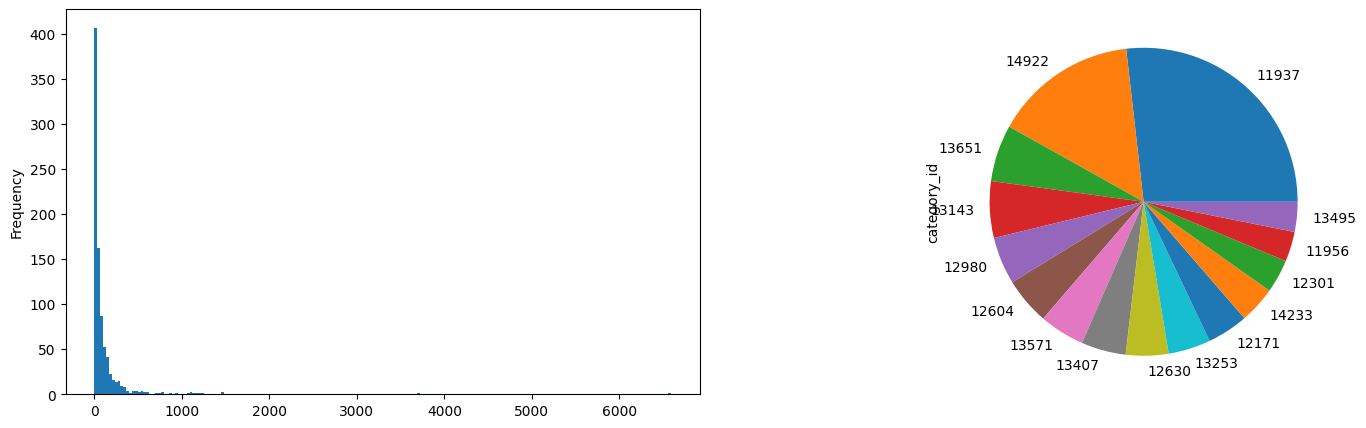

In [4]:
print('Total categories:', len(full_train_data.category_id.unique()))
print(full_train_data.category_id.value_counts())
fig, (ax1, ax2) = plt.subplots(1, 2, **{'figsize':(18, 5)})
full_train_data.category_id.value_counts().plot(kind='hist', **{'bins':200}, ax=ax1)
full_train_data.category_id.value_counts()[:15].plot.pie()

Взглянем на колонку "shop_id". \
(Видим, что магазинов очень много, распределение неравномерное, сложно использовать их для предсказания, скорее всего, эту колонку придется просто удалить, наименование магазина уже есть)

Total shops: 10549
2223     1178
28813     895
11132     843
19665     602
12163     559
         ... 
39847       1
43078       1
19212       1
39036       1
53732       1
Name: shop_id, Length: 10549, dtype: int64


<AxesSubplot: ylabel='shop_id'>

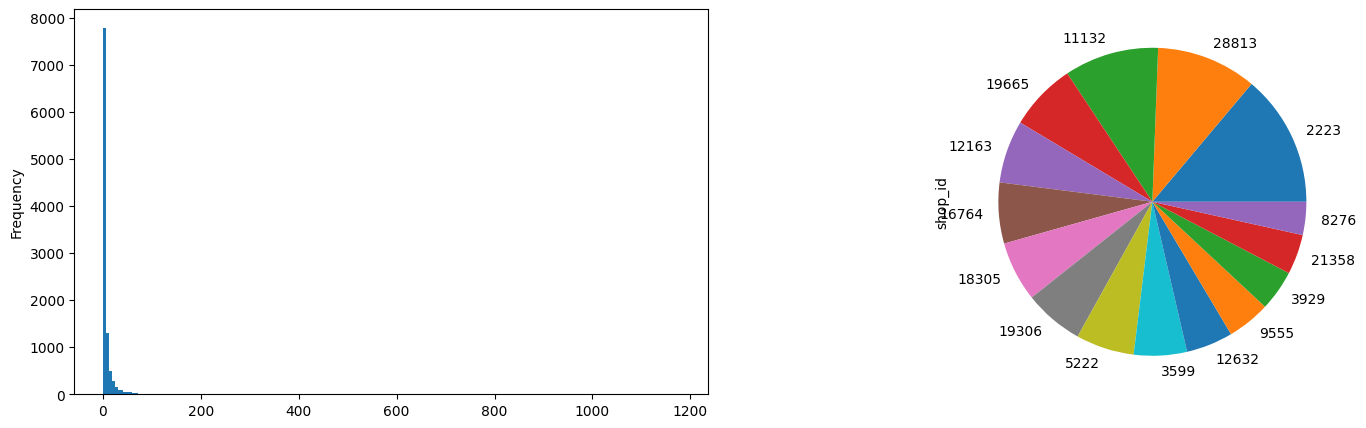

In [5]:
print('Total shops:', len(full_train_data.shop_id.unique()))
print(full_train_data.shop_id.value_counts())
fig, (ax1, ax2) = plt.subplots(1, 2, **{'figsize':(18, 5)})
full_train_data.shop_id.value_counts().plot(kind='hist', **{'bins':200}, ax=ax1)
full_train_data.shop_id.value_counts()[:15].plot.pie()

Посмотрим, сколько товаров продаются со скидкой.

In [6]:
print(full_train_data.sale.value_counts())

False    89896
True      1224
Name: sale, dtype: int64


Рейтинг товара неизвестен на момент добавления его в каталог, эту колонку необходимо просто удалить.

Рассмотрим подробнее колонку "text_fields": это словарь, видимо, сериализованный в json:\
(Я склонен преобразовать эту сложную структуру данных в более-менее человекочитаемую строку, и подавать на вход моделям типа BERT или FastText.)

In [7]:
text_fields_list = [json.loads(x) for x in full_train_data.text_fields.tolist()]
field_0 = text_fields_list[0]
for k, v in field_0.items():
    print(k, ":", v, '\n')

title : Зарядный кабель Borofone BX1 Lightning для айфон, 1м 

description : <p><span style="background-color: transparent; color: rgb(0, 26, 52);">Зарядный кабель Borofone BX1 подходит для зарядки всех гаджетов и аксессуаров с разъемом </span>Lightning.</p><p><span style="color: rgb(0, 26, 52); background-color: transparent;">Поддерживает быструю зарядку.</span></p><p><span style="color: rgb(0, 26, 52); background-color: transparent;">Подходит для передачи данных.</span></p> 

attributes : ['Длина: 1м', 'Разъем: Lightning', 'Подерживает быструю зарядку', 'Максимальный ток: 2.0А', 'Для зарядки и синхронизации данных', 'Вес: 22 г.'] 

custom_characteristics : {} 

defined_characteristics : {'Цвет': ['Черный', 'Белый']} 

filters : {'Цвет': ['Белый', 'Черный']} 

